In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_flow(path, src_ip, dst_ip):
    data = pd.read_csv(path)
    raw_data = data.values

    clean_data = []
    flows = []

    # 패킷의 전송 간격을 구함
    interval = []
    last = 0
    for line in raw_data:
        if line[2] == src_ip and line[3] == dst_ip:
            interval.append(line[1]-last)
            last = line[1]
            clean_data.append(line)

    # 패킷 평균 전송 간격
    avg = sum(interval) / len(interval)

    diverge = []

    i = 0
    # 평균 전송간격보다 큰 경우 flow를 분리를 위한 인덱스 찾기
    for t in interval:
        if t >= avg:
            diverge.append(i)
        i = i + 1

    # 찾은 인덱스로 flow를 분리
    prefix = 0
    for idx in diverge:
        if idx >= len(clean_data):
            break
        flow = clean_data[prefix:idx]
        flows.append(flow)
        prefix = idx + 1

    if len(flows) < 100:
        return 0
    print("## 총 ", len(flows), "개의 flow 발견")

    # 평균 인터벌
    avg_ivl = []
    # 평균 페이로드 크기
    avg_pay = []
    # 평균 패킷 수
    avg_cnt = []
    # 프로토콜 넘뻐
    pcl = []

    for flow in flows:
        last = 0
        ivl = 0
        payload = 0
        if len(flow) <= 0:
            continue
        for line in flow:
            ivl = ivl + (line[1]-last)
            last = line[1]
            payload = payload + line[5]

        # 값 입력
        avg_ivl.append(ivl / len(flow))
        avg_pay.append(payload / len(flow))
        avg_cnt.append(len(flow))
        pcl.append(flow[0][4])

    return [avg_ivl, avg_cnt, avg_pay, pcl]


In [ ]:
# for preprocessing only
def data_process(path):
    nm = path.split('/')[3]
    print(nm)
    data = pd.read_csv(path)
    src_set = set(data["ip.src"])
    
    rl = np.array([])
    
    for ips in src_set:
        if type(ips) == float:
            continue
        dst_set = set(data[data["ip.src"] == ips]["ip.dst"])
        for ipd in dst_set:
            tmp = get_flow(path, ips, ipd)
            if tmp != 0:
                tmp = np.array(tmp)
                if len(rl) == 0:
                    rl = tmp
                else:
                    rl = np.hstack((rl, tmp))
    rl = pd.DataFrame(rl.transpose(), columns=['ivl', 'cnt', 'pay', 'pcl'])
    print(rl)
    rl.to_csv("./processed/VPN/" + nm + "_processed.csv", index=False)

In [ ]:
data_process("./Datasets/VPN/Chat/merge.csv")
data_process("./Datasets/VPN/Email/merge.csv")
data_process("./Datasets/VPN/FileTransfer/merge.csv")
data_process("./Datasets/VPN/P2P/merge.csv")
data_process("./Datasets/VPN/Streaming/merge.csv")
data_process("./Datasets/VPN/VoIP/merge.csv")

In [7]:
"""
# for origin data only
low_flow = get_flow("./30sec_server.csv", '10.0.0.1', '10.0.0.2')
high_flow = get_flow("./Datasets/nonVPN/Chat/merge.csv", '131.202.240.87', '10.0.0.2')
chat_flow = get_flow("./chat_server.csv", '10.0.0.1', '10.0.0.2')
"""
target_nm = 1
class_nm = ['Chat', 'Email', 'FileTransfer', 'P2P', 'Streaming', 'VoIP']
oposit_data = []
for i in range(len(class_nm)):
    if i == target_nm:
        target_data = pd.read_csv("./processed/" + class_nm[i] + "_processed.csv").drop(['pcl'], axis=1).values
        print(target_data)
    else:
        oposit_data.extend(pd.read_csv("./processed/" + class_nm[i] + "_processed.csv").drop(['pcl'], axis=1).values)
        
target_data = np.array(target_data)
print(len(target_data))
#oposit_data = np.array(oposit_data[150000:300000])
print(len(oposit_data))



[[0.00000000e+00 1.00000000e+00 5.20000000e+01]
 [3.70336667e-02 6.00000000e+00 9.08333333e+02]
 [2.67623667e-01 3.00000000e+00 6.06666667e+02]
 ...
 [1.21606444e+03 1.00000000e+00 9.60000000e+01]
 [1.21646005e+03 1.00000000e+00 9.60000000e+01]
 [1.21685040e+03 1.00000000e+00 9.20000000e+01]]
1709
551296


In [3]:
print(target_data[:10000])
print(oposit_data[:10000])

[[0.00000000e+00 1.00000000e+00 5.20000000e+01]
 [3.70336667e-02 6.00000000e+00 9.08333333e+02]
 [2.67623667e-01 3.00000000e+00 6.06666667e+02]
 ...
 [1.21606444e+03 1.00000000e+00 9.60000000e+01]
 [1.21646005e+03 1.00000000e+00 9.60000000e+01]
 [1.21685040e+03 1.00000000e+00 9.20000000e+01]]
[[1.33736492e+03 2.00000000e+00 1.25000000e+02]
 [2.67477034e+03 1.00000000e+00 1.25000000e+02]
 [1.33742487e+03 2.00000000e+00 1.25000000e+02]
 ...
 [1.60890643e+03 2.00000000e+00 1.25000000e+02]
 [3.21785307e+03 1.00000000e+00 1.25000000e+02]
 [1.60897636e+03 2.00000000e+00 1.25000000e+02]]


In [8]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()
scaler.fit(target_data)
target_data = scaler.transform(target_data)

In [11]:
scaler.fit(oposit_data)
oposit_data = scaler.transform(oposit_data)

In [12]:
target_data = pd.DataFrame({'interval': target_data[:, 0], 'count': target_data[:, 1], 'size': target_data[:, 2], 'label': 0})
oposit_data = pd.DataFrame({'interval': oposit_data[:, 0], 'count': oposit_data[:, 1], 'size': oposit_data[:, 2], 'label': 1})

In [13]:
full_data = pd.concat([target_data, oposit_data])

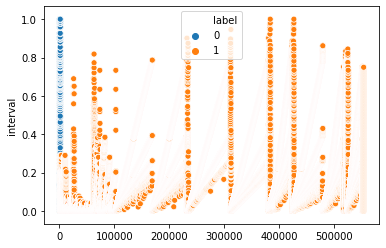

In [14]:
sns.scatterplot(x=range(len(full_data['interval'])), y=full_data['interval'], hue=full_data['label'])

In [15]:
from sklearn.cluster import KMeans, DBSCAN

In [16]:
X = full_data.drop(['label'], axis=1)
Y = full_data['label']

In [17]:
kmeans = KMeans(n_clusters=2).fit(X.values)
X['cid'] = kmeans.labels_

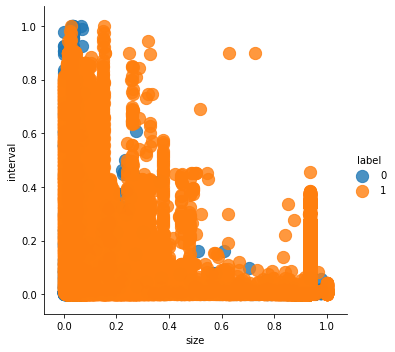

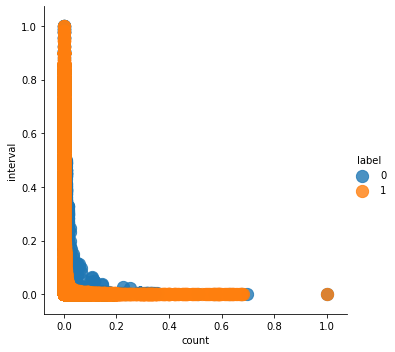

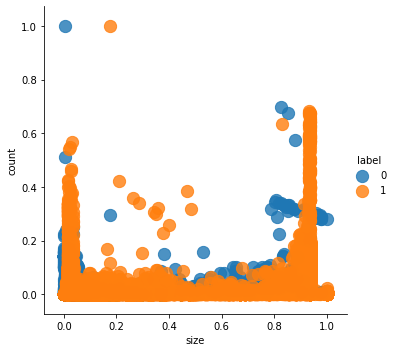

In [18]:
sns.lmplot('size', 'interval', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')
sns.lmplot('count', 'interval', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')
sns.lmplot('size', 'count', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')

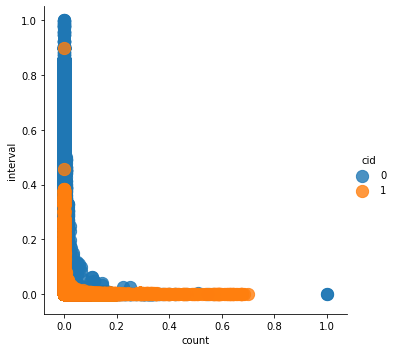

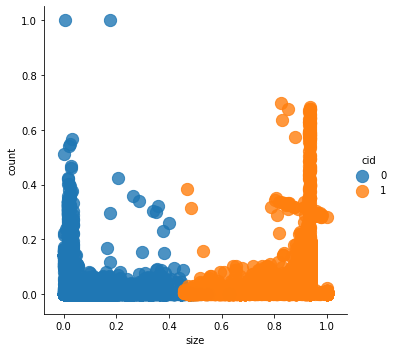

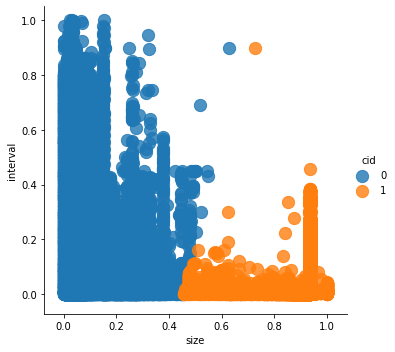

In [19]:
sns.lmplot('count', 'interval', data=X, fit_reg=False, scatter_kws={'s':150}, hue='cid')
sns.lmplot('size', 'count', data=X, fit_reg=False, scatter_kws={'s':150}, hue='cid')
sns.lmplot('size', 'interval', data=X, fit_reg=False, scatter_kws={'s':150}, hue='cid')

In [20]:
y_pred = list(kmeans.labels_)
scoreY = list(Y)
hit = 0
for i in range(0, len(y_pred)):
    if y_pred[i] == scoreY[i]:
        hit = hit + 1
print(hit/len(scoreY))

0.10585256914494444


In [21]:
X = X.drop(['cid'], axis=1)

In [ ]:
dbscan = DBSCAN(eps=1, min_samples=3000).fit(X)

In [ ]:
y_pred = dbscan.fit_predict(X)
X['cid'] = y_pred

In [ ]:
sns.lmplot('size', 'interval', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')
sns.lmplot('count', 'interval', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')
sns.lmplot('size', 'count', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')

In [ ]:
sns.lmplot('count', 'interval', data=X, fit_reg=False, scatter_kws={'s':50}, hue='cid')
sns.lmplot('size', 'count', data=X, fit_reg=False, scatter_kws={'s':50}, hue='cid')
sns.lmplot('size', 'interval', data=X, fit_reg=False, scatter_kws={'s':50}, hue='cid')

In [ ]:
hit = 0
for i in range(0, len(y_pred)):
    if (y_pred[i] + scoreY[i]) == 0:
        hit = hit + 1
print(hit/len(scoreY))

In [8]:
import tensorflow as tf
import time
from dagmm import DAGMM

In [9]:
full_data = pd.concat([target_data, oposit_data])
X = full_data.drop(['label'], axis=1)

In [10]:
tf.reset_default_graph()

In [12]:
model_dagmm = DAGMM(
    comp_hiddens=[16, 8,1], comp_activation=tf.nn.tanh,
    est_hiddens=[8,4], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=200, minibatch_size=300
)

In [13]:
start = time.time()
model_dagmm.fit(X)
end = time.time()
print("Learning time = ", end-start)

InternalError: tensorflow/core/kernels/cuda_solvers.cc:375: cuSolverDN call failed with status =7
	 [[Node: GMM/Cholesky = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GMM/add)]]

Caused by op 'GMM/Cholesky', defined at:
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-a752b3805b85>", line 2, in <module>
    model_dagmm.fit(X)
  File "/home/inns-mainframe-1/Documents/GitHub/IMCOM2020/dagmm/dagmm.py", line 119, in fit
    self.gmm.fit(z, gamma)
  File "/home/inns-mainframe-1/Documents/GitHub/IMCOM2020/dagmm/gmm.py", line 53, in fit
    self.L = tf.cholesky(sigma + min_vals[None,:,:])
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 707, in cholesky
    "Cholesky", input=input, name=name)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/inns-mainframe-1/anaconda3/envs/tf/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InternalError (see above for traceback): tensorflow/core/kernels/cuda_solvers.cc:375: cuSolverDN call failed with status =7
	 [[Node: GMM/Cholesky = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](GMM/add)]]


In [33]:
full_data = pd.concat([target_data, oposit_data])
X = full_data.drop(['label'], axis=1)
Y = full_data['label']

In [34]:
energy = model_dagmm.predict(X)

Text(0, 0.5, 'Number of Sample(s)')

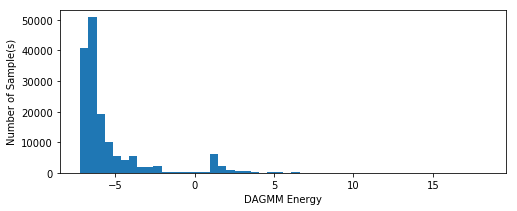

In [35]:
plt.figure(figsize=[8,3])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")

In [36]:
energy.sort()
threshold = len(energy)*0.9
print(threshold)
threshold = energy[-int(threshold)]
print(threshold)
cid = []
for node in energy:
    if node > threshold:
        cid.append(1)
    else:
        cid.append(0)

139280.4
-6.884791


In [37]:
X['cid'] = cid
X['energy'] = energy
X['label'] = Y

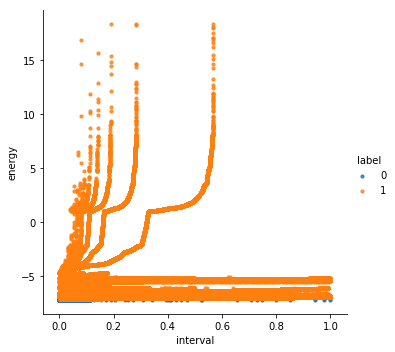

In [38]:
sns.lmplot('interval', 'energy', data=X, fit_reg=False, scatter_kws={'s':10}, hue='label')

In [39]:
y_pred = list(X['cid'])
scoreY = list(X['label'])
hit = 0
for i in range(0, len(y_pred)):
    if y_pred[i] == scoreY[i] and scoreY[i] == 1:
        hit = hit + 1
print("PP", hit/len([x for x in scoreY if x == 1]))

hit = 0
for i in range(0, len(y_pred)):
    if y_pred[i] == scoreY[i] and scoreY[i] == 0:
        hit = hit + 1
print("FF", hit/len([x for x in scoreY if x == 0]))

hit = 0
for i in range(0, len(y_pred)):
    if y_pred[i] != scoreY[i] and scoreY[i] == 0:
        hit = hit + 1
print("PF", hit/len([x for x in scoreY if x == 0]))

hit = 0
for i in range(0, len(y_pred)):
    if y_pred[i] != scoreY[i] and scoreY[i] == 0:
        hit = hit + 1
print("FP", hit/len([x for x in scoreY if x == 1]))

for i in range(0, len(y_pred)):
    if y_pred[i] == scoreY[i]:
        hit = hit + 1
print("Accuracy", hit/len(scoreY))

PP 0.9285266666666666
FF 1.0
PF 0.0
FP 0.0
Accuracy 0.9307232029775905


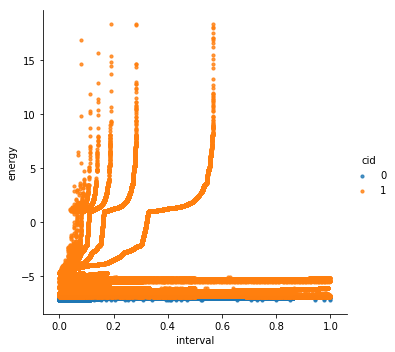

In [40]:
sns.lmplot('interval', 'energy', data=X, fit_reg=False, scatter_kws={'s':10}, hue='cid')